# AG NEWS NLP PROJECT

AG News is a subdataset of AG's corpus of news articles constructed by assembling titles and description fields of articles from the 4 largest classes (“World”, “Sports”, “Business”, “Sci/Tech”) of AG’s Corpus. This dataset is also commonly used for experimenting with Natural Language Processing and more specifically text classification models in the machine learning community. 

You can check the papers about the models that achieve the state-of-the-art results on this dataset from this link: https://paperswithcode.com/sota/text-classification-on-ag-news. 

I will go through several modelling experiments to display my knowledge in natural language processing and to see how close I can get to the state of the art results. 

Modelling Experiments Outline:

* `Model_0 (Baseline)`: Multinomial Naive Bayes with TD-IDF
* `Model_1`: 1D Convolutional Neural Network With Custom Token Embeddings
* `Model_2`: Universal Sentence Encoder Feature Extraction
* `Model_3`: 1D Convolutional Neural Network With Custom Token Embeddings Combined With Bi-LSTM With Custom Character Embeddings 
* `Model_4`: LSTM Model With BERT Feature Extraction 
* `Model_5`: 1D Convolutional Neural Network With BERT Tokem Embeddings Combined With Bi-LSTM With Custom Character Embeddings 

## Importing the Dependencies

In [38]:
!pip install datasets

In [39]:
!pip install tensorflow-text

In [40]:
!pip install transformers

In [41]:
from datasets import list_datasets, list_metrics, load_dataset
from pprint import pprint

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import string
import random


## Donwloading the Dataset

In [42]:
# Accessing various attributes of the ag_news dataset before downloading it
datasets = list_datasets()
metrics = list_metrics()
dataset_info = list_datasets(with_details=True)[datasets.index('ag_news')]
pprint(dataset_info.__dict__)

{'author': None,
 'citation': '@inproceedings{Zhang2015CharacterlevelCN,\n'
             '  title={Character-level Convolutional Networks for Text '
             'Classification},\n'
             '  author={Xiang Zhang and Junbo Jake Zhao and Yann LeCun},\n'
             '  booktitle={NIPS},\n'
             '  year={2015}\n'
             '}',
 'description': 'AG is a collection of more than 1 million news articles. News '
                'articles have been\n'
                'gathered from more than 2000 news sources by ComeToMyHead in '
                'more than 1 year of\n'
                'activity. ComeToMyHead is an academic news search engine '
                'which has been running\n'
                'since July, 2004. The dataset is provided by the academic '
                'comunity for research\n'
                'purposes in data mining (clustering, classification, etc), '
                'information retrieval\n'
                '(ranking, search, etc), xml, data compre

In [43]:
dataset = load_dataset('ag_news')

Using custom data configuration default
Reusing dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


## Exploring the Dataset

In [44]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [45]:
# Looking at a sample from the training dataset
dataset['train'][0]

{'label': 2,
 'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."}

In [46]:
# Visualizing the label counts
pd.Series(dataset['train']['label']).value_counts()

3    30000
2    30000
1    30000
0    30000
dtype: int64

In [47]:
pd.Series(dataset['test']['label']).value_counts()

3    1900
2    1900
1    1900
0    1900
dtype: int64

Both datasets are prefectly balanced

The labels are encoded accordingly:

* 0: World
* 1: Sports
* 2: Business
* 3: Sci/Tech

For more information you can check the link: https://huggingface.co/datasets/ag_news

In [48]:
# Creating variables for class names and number of classes
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
num_classes = len(class_names)

## Preprocessing the Data

In [49]:
# Creating different variables for train, validation and test sets
train_dataset = pd.DataFrame(dataset['train'])
test_dataset = pd.DataFrame(dataset['test'])
print(len(train_dataset), len(test_dataset))

120000 7600


In [50]:
# Visualizing the training dataset
train_dataset.head(10)

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
5,"Stocks End Up, But Near Year Lows (Reuters) Re...",2
6,Money Funds Fell in Latest Week (AP) AP - Asse...,2
7,Fed minutes show dissent over inflation (USATO...,2
8,Safety Net (Forbes.com) Forbes.com - After ear...,2
9,Wall St. Bears Claw Back Into the Black NEW Y...,2


In [51]:
# Shuffling the training dataframe
train_dataset = train_dataset.sample(frac=1, random_state=57) # shuffle with random_state=57 for reproducibility
train_dataset

,text,label
27510,ABB won #39;t close Guelph transformer plant A...,2
84528,Poison pill for News NEWS Corporation yesterda...,2
96252,Does Your Site Need a Custom Search Engine Too...,3
92001,Europe's Mission to Moon Nears Lunar Orbit (AP...,3
26401,Neville injury is a blow for United and Englan...,1
...,...,...
85071,Stocks End Higher on Falling Oil Prices Stocks...,2
110998,Japanese Troops Authorised to Stay in Iraq Jap...,0
35845,"Zero G Flights Could Bolster Space Tourism, Re...",3
11990,Friday Olympic Preview: How will Marion do? Da...,1


In [52]:
# Creating different variables (lists) for text and labels for each dataset
train_text = train_dataset['text'].tolist()
test_text = test_dataset['text'].tolist()

train_labels = train_dataset['label'].tolist()
test_labels = test_dataset['label'].tolist()

In [53]:
# One hot-encoding the labels for deep models
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_dataset['label'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_dataset['label'].to_numpy().reshape(-1, 1))

# Checking what training labels look like
train_labels_one_hot

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

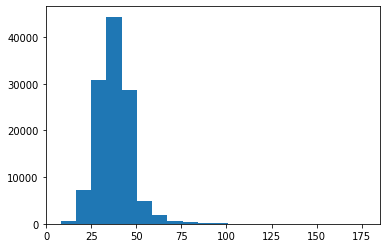

In [54]:
# Checking the statement length distribution for the training set
statement_lengths = [len(statement.split()) for statement in train_text]
plt.hist(statement_lengths, bins=20);

In [18]:
# Checking the statement length that covers 95% of the statements
output_seq_len = int(np.percentile(statement_lengths, 95))
output_seq_len

53

## Baseline Model: TF-IDF MultinomialNB

In [19]:
# Creating tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fitting the pipeline to the training data
model_0.fit(train_text, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [20]:
# Evaluating the baseline model on the evaluation set
baseline_score = model_0.score(test_text, test_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 90.21%


## Creating Embedding Layers for the Deep Models


### Custom Token Embedding Layer

In [21]:
# Creating a text vectorization layer 
text_vectorizer = TextVectorization(output_sequence_length=output_seq_len) # output_seq_len is set to 53

In [22]:
# Adapting the text vectorizer to training statements
text_vectorizer.adapt(train_text)

In [23]:
# Testing out the text vectorizer on random sentences
random_text=random.choice(train_text)
print(f"Text:\n{random_text}")
print(f"\nLength of text: {len(random_text.split())}")
print(f"\nVectorized text:\n{text_vectorizer([random_text])}")

Text:
Michigan Forces Turnovers for 30-17 Win (AP) AP - Braylon Edwards caught six passes for 150 yards and a touchdown and No. 18 Michigan turned four turnovers into 27 points in a 30-17 win over Iowa on Saturday.

Length of text: 38

Vectorized text:
[[ 1409   325  6121     9 30539    98    26    26 19410  2429  2351   338
   1422     9  3146   822     7     4  1168     7    69   619  1409  1093
    147  6121    55  1324   321     6     4 30539    98    32  3499     8
    104     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]


In [24]:
# Checking the length of the vocab size and top 5 most and least common words
tab_fact_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(tab_fact_text_vocab)}"), 
print(f"Most common words in the vocabulary: {tab_fact_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {tab_fact_text_vocab[-5:]}")

Number of words in vocabulary: 102171
Most common words in the vocabulary: ['', '[UNK]', 'the', 'to', 'a']
Least common words in the vocabulary: ['0029', '0013', '000th', '000strong', '000660se']


In [25]:
# Creating the embedding layer
token_embed = layers.Embedding(input_dim=len(tab_fact_text_vocab),
                               output_dim=128, # I chose 128, but it is a hyperparameter and we can experiment with different numbers
                               mask_zero=True, 
                               name='token_embedding')

In [26]:
# Testing the embedding layer on a random sample
print(f"Sentence before vectorization:\n{random_text}\n")
vectorized_sentence = text_vectorizer([random_text])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
Michigan Forces Turnovers for 30-17 Win (AP) AP - Braylon Edwards caught six passes for 150 yards and a touchdown and No. 18 Michigan turned four turnovers into 27 points in a 30-17 win over Iowa on Saturday.

Sentence after vectorization (before embedding):
[[ 1409   325  6121     9 30539    98    26    26 19410  2429  2351   338
   1422     9  3146   822     7     4  1168     7    69   619  1409  1093
    147  6121    55  1324   321     6     4 30539    98    32  3499     8
    104     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04054881 -0.02407131 -0.03212489 ... -0.00277494  0.03059236
    0.025927  ]
  [ 0.04389056 -0.00075965 -0.00947731 ... -0.02243254 -0.0430246
   -0.02014445]
  [-0.02100829 -0.01400813  0.03629397 ... -0.01680348 -0.00889951
   -0.03504385]
  ...
  [-0.01647451 -0.00070108 -0.03710514 ...  0.02840817 -0.03408928
   -0.04454679]
  [-0.01647451 -

### Custom Character Embedding Layer

In [27]:
# Making a function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Testing the function on the random sample
split_chars(random_text)

'M i c h i g a n   F o r c e s   T u r n o v e r s   f o r   3 0 - 1 7   W i n   ( A P )   A P   -   B r a y l o n   E d w a r d s   c a u g h t   s i x   p a s s e s   f o r   1 5 0   y a r d s   a n d   a   t o u c h d o w n   a n d   N o .   1 8   M i c h i g a n   t u r n e d   f o u r   t u r n o v e r s   i n t o   2 7   p o i n t s   i n   a   3 0 - 1 7   w i n   o v e r   I o w a   o n   S a t u r d a y .'

In [28]:
# Turn sequence-level data splits into character-level data splits
train_chars = [split_chars(text) for text in train_text]
test_chars = [split_chars(text) for text in test_text]
train_chars[0]

'A B B   w o n   # 3 9 ; t   c l o s e   G u e l p h   t r a n s f o r m e r   p l a n t   A B B   I n c .   h a s   r e v e r s e d   a   d e c i s i o n   t o   c l o s e   i t s   t r a n s f o r m e r   p l a n t   i n   G u e l p h ,   O n t . ,   s a v i n g   3 0 0   j o b s ,   t h e   u n i o n   r e p r e s e n t i n g   t h e   w o r k e r s   s a i d   t o d a y .'

In [29]:
# Finding the average character length?
char_lens = [len(text) for text in train_text]
mean_char_len = np.mean(char_lens)
mean_char_len

236.477525

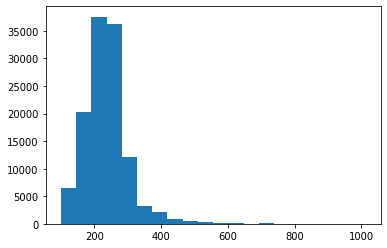

In [55]:
# Checking the distribution of our sequences at character-level
plt.hist(char_lens, bins=20);

In [ ]:
# Checking the character length that covers 95% of the statements
output_char_len = int(np.percentile(char_lens, 95))
output_char_len

343

In [ ]:
# Getting all keyboard characters for char-level embedding
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Creating char-level token vectorizer instance
num_char_tokens = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=num_char_tokens,  
                                    output_sequence_length= output_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapting character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Checking character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 38
5 most common characters: ['', '[UNK]', 'e', 'a', 't']
5 least common characters: ['5', '4', '6', '7', '8']


In [ ]:
# Creating the character level embedding layer
char_embed = layers.Embedding(input_dim=num_char_tokens,
                              output_dim=128, 
                              mask_zero=True,
                              name="char_embed")

### Universal Sentence Encoder Embedding Layer

In [ ]:
# Downloading pretrained TensorFlow Hub USE
use_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable = False,
                                        name='universal_sentence_encoder')

### BERT Embedding Layer

In [ ]:
# Downloading the Bert Transformer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", 
    trainable=False)
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768]
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768]
bert_embedding_model = tf.keras.Model(text_input, sequence_output)

In [ ]:
print(f"Sentence before vectorization:\n{target_text}\n")
embedded_sentence = bert_embedding_model(tf.constant([target_text]))
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
Mariners reportedly land Beltre com. One day after signing a right-handed hitter with two 45-home runs seasons on his resume, the Mariners could be on the verge of signing the current Major League home run champion.

Sentence after embedding:
[[[-0.42464095 -0.21131477  0.2954899  ... -0.31684673  0.48595876
    0.3248234 ]
  [ 0.78360885  0.00165011  0.07729433 ... -0.2681083   0.4298331
    0.1227963 ]
  [ 0.41341433 -0.17600237  0.1030999  ... -0.11583686  0.2737989
   -0.30665642]
  ...
  [-0.5939698  -0.46450517  0.27629188 ...  0.5174491   0.45493597
   -0.3546823 ]
  [-0.5966434  -0.4462755   0.24950106 ...  0.53510547  0.3247217
   -0.28557107]
  [-0.27720377 -0.54359245  0.19970278 ...  0.65216243  0.4818318
   -0.33545652]]]

Embedded sentence shape: (1, 128, 768)


## Creating Datasets for the Deep Models


I am going to set up our data to run as fast as possible with TensorFlow tf.data.API, many of the steps here are discussed at length in these two resources:
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (4,)), types: (tf.string, tf.float64)>

In [ ]:
# Batching the TensorSlicedDatasets and prefetching them
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None,), (None, 4)), types: (tf.string, tf.float64)>
<PrefetchDataset shapes: ((None,), (None, 4)), types: (tf.string, tf.float64)>


In [ ]:
# Creating datasets with combined character level and token level data
char_token_train =  tf.data.Dataset.from_tensor_slices((train_text, train_chars)) 
char_token_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_char_token_dataset = tf.data.Dataset.zip((char_token_train, char_token_train_labels))

# Prefetching and batching the train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeating the same process for the test dataset
char_token_test = tf.data.Dataset.from_tensor_slices((test_text, test_chars)) 
char_token_test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) 
test_char_token_dataset = tf.data.Dataset.zip((char_token_test, char_token_test_labels))

test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Deep Modelling Experiments

In [ ]:
# Creating a function to evaluate the models in terms of accuracy, precision, recall, f1 and save the results
results = {}
def evaluate_model(model, test_data):
  model_accuracy = model.evaluate(test_data)[1]
  y_pred_probs = model.predict(test_data) # getting the prediction probabilities
  y_pred = tf.argmax(y_pred_probs, axis=1) # turning the prediction probabilities into prediction classes
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  results[f'{model.name}'] =  model_results

### Model 1: Conv1D with Custom Token Embeddings

In [ ]:
# Creating the model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors) 
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='model_1_conv1d_token_embedding')

# compiling the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1_conv1d_token_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_2 (TextVe (None, 53)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 53, 128)           13077888  
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 53, 64)            41024     
_________________________________________________________________
global_average_pooling1d_6 ( (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 260       
Total params: 13,119,172
Trainable params: 13,119,172
Non-trainable params: 0
________________________

In [ ]:
# fitting the model
model_1_hist = model_1.fit(train_dataset,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           epochs=10,
                           validation_data=test_dataset,
                           validation_steps = int(0.1*len(test_dataset)))

Epoch 1/10
375/375 [==============================] - 48s 126ms/step - loss: 0.6301 - accuracy: 0.7710 - val_loss: 0.4366 - val_accuracy: 0.8573
Epoch 2/10
375/375 [==============================] - 47s 125ms/step - loss: 0.3181 - accuracy: 0.8978 - val_loss: 0.3905 - val_accuracy: 0.8614
Epoch 3/10
375/375 [==============================] - 47s 125ms/step - loss: 0.2911 - accuracy: 0.9048 - val_loss: 0.3691 - val_accuracy: 0.8764
Epoch 4/10
375/375 [==============================] - 47s 124ms/step - loss: 0.2888 - accuracy: 0.9048 - val_loss: 0.3631 - val_accuracy: 0.8668
Epoch 5/10
375/375 [==============================] - 46s 123ms/step - loss: 0.2564 - accuracy: 0.9172 - val_loss: 0.3370 - val_accuracy: 0.8859
Epoch 6/10
375/375 [==============================] - 47s 125ms/step - loss: 0.2665 - accuracy: 0.9088 - val_loss: 0.3111 - val_accuracy: 0.8886
Epoch 7/10
375/375 [==============================] - 47s 124ms/step - loss: 0.2488 - accuracy: 0.9200 - val_loss: 0.2999 - val_ac

In [ ]:
evaluate_model(model_1, test_dataset)

238/238 [==============================] - 1s 4ms/step - loss: 0.2497 - accuracy: 0.9183


### Model 2: Universal Sentence Encoder Feature Extraction Model

In [ ]:
# Creating the model
inputs = layers.Input(shape=(), dtype=tf.string)
embeddings = use_embedding(inputs)
x = layers.Dense(256, activation='relu')(embeddings)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='model_2_USE_token_embedding')

# compiling the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_token_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 516       
Total params: 256,962,564
Trainable params: 164,740
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# fitting the model
model_2_hist = model_2.fit(train_dataset,
                           steps_per_epoch=int(0.1*len(train_dataset)),
                           epochs=10,
                           validation_data=test_dataset,
                           validation_steps = int(0.1*len(test_dataset)))

Epoch 1/10
375/375 [==============================] - 7s 14ms/step - loss: 0.4091 - accuracy: 0.8631 - val_loss: 0.3884 - val_accuracy: 0.8750
Epoch 2/10
375/375 [==============================] - 5s 13ms/step - loss: 0.3194 - accuracy: 0.8851 - val_loss: 0.3480 - val_accuracy: 0.8818
Epoch 3/10
375/375 [==============================] - 5s 13ms/step - loss: 0.3005 - accuracy: 0.8942 - val_loss: 0.3474 - val_accuracy: 0.8913
Epoch 4/10
375/375 [==============================] - 5s 12ms/step - loss: 0.2970 - accuracy: 0.8968 - val_loss: 0.3471 - val_accuracy: 0.8777
Epoch 5/10
375/375 [==============================] - 5s 12ms/step - loss: 0.2795 - accuracy: 0.9007 - val_loss: 0.3358 - val_accuracy: 0.8750
Epoch 6/10
375/375 [==============================] - 5s 12ms/step - loss: 0.2879 - accuracy: 0.8967 - val_loss: 0.3333 - val_accuracy: 0.8832
Epoch 7/10
375/375 [==============================] - 5s 12ms/step - loss: 0.2751 - accuracy: 0.9035 - val_loss: 0.3262 - val_accuracy: 0.8913

In [ ]:
evaluate_model(model_2, test_dataset)

238/238 [==============================] - 3s 11ms/step - loss: 0.2823 - accuracy: 0.9030


### Model 3: Conv1D with Custom Token Embeddings Combined with Caracter Level Embeddings with Bi-LSTM Layers

In [ ]:
# resetting the token vectorizer and the embedding layer to reset learned patterns from the previous experiment
text_vectorizer.adapt(train_text)
token_embed = layers.Embedding(input_dim=len(tab_fact_text_vocab),
                               output_dim=256, 
                               mask_zero=True, 
                               name='token_embedding')

In [ ]:
# Setting up token inputs/model
token_inputs = token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
text_vectors = text_vectorizer(token_inputs)
token_embeddings = token_embed(text_vectors) 
x = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
token_output = layers.Dense(64, activation="relu")(x)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setting up character inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(char_embeddings)
char_output = layers.Bidirectional(layers.LSTM(64))(char_bi_lstm)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_output)

# 3. Concatenating token and char inputs 
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Creating output layers 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(256, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Constructing the multimodal model with character and token inputs
model_3 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_3_bilstm_char_conv1d_token_embedding")

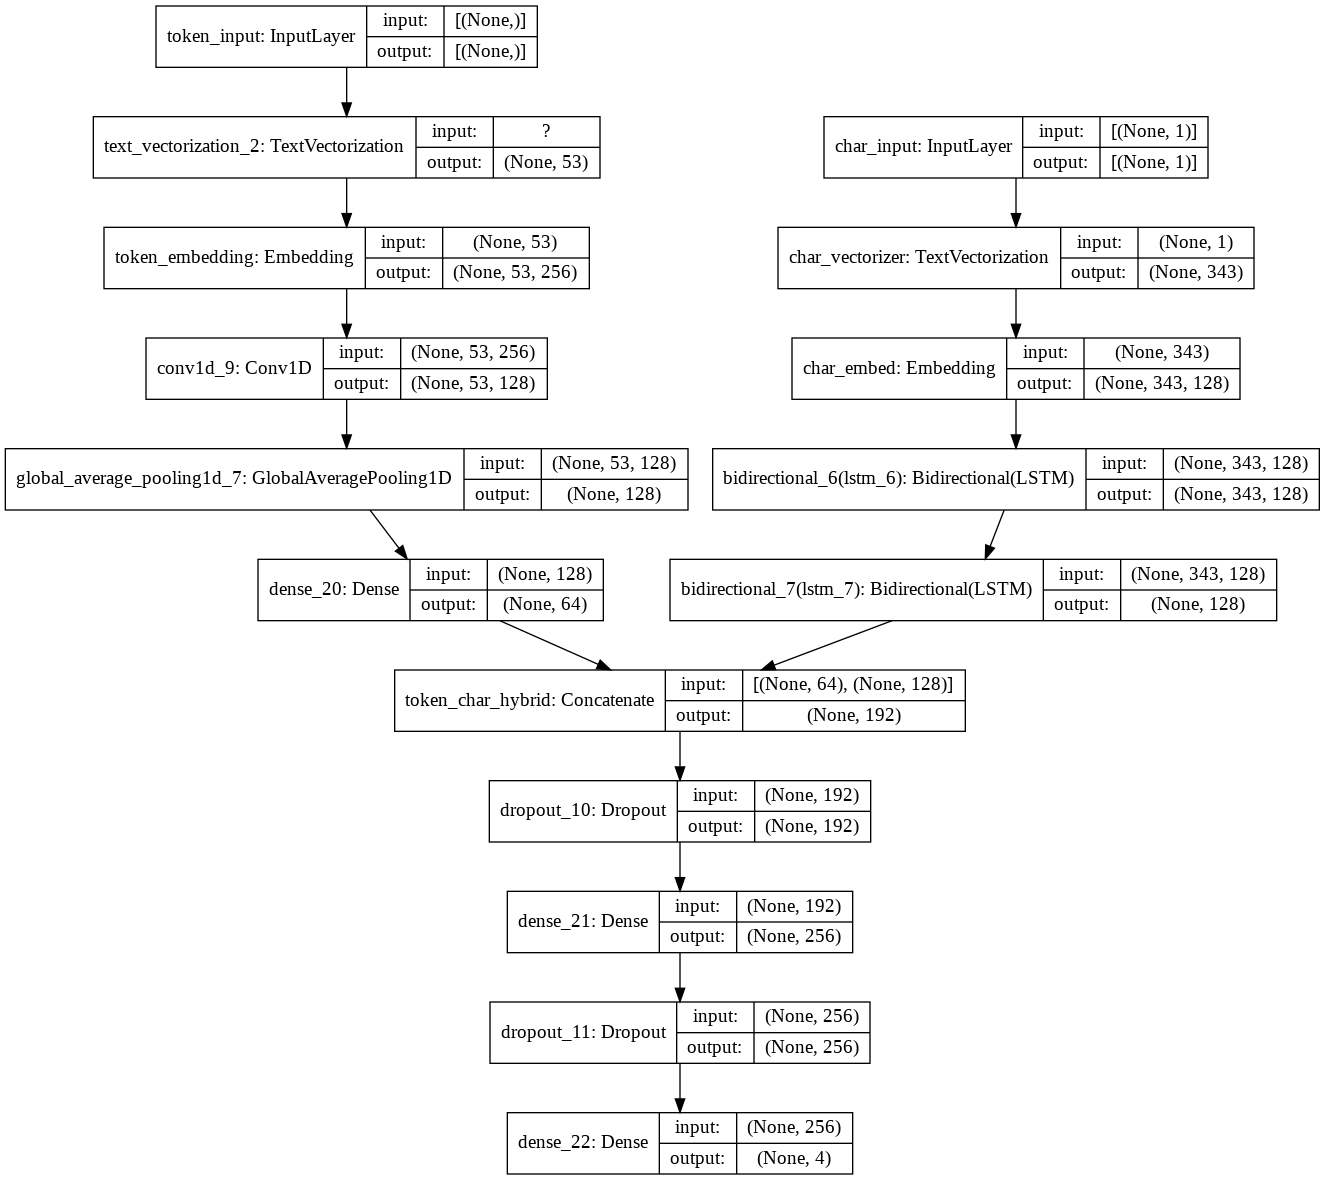

In [ ]:
# Plotting the hybrid token and character model
plot_model(model_3, show_shapes=True)

In [ ]:
# compiling the model
model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
# fitting the model
model_3_hist = model_3.fit(train_char_token_dataset, 
                            steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                            epochs=10,
                            validation_data=test_char_token_dataset,
                            validation_steps=int(0.1 * len(test_char_token_dataset)))

Epoch 1/10
375/375 [==============================] - 126s 303ms/step - loss: 0.6817 - accuracy: 0.7225 - val_loss: 0.4623 - val_accuracy: 0.8370
Epoch 2/10
375/375 [==============================] - 110s 292ms/step - loss: 0.3756 - accuracy: 0.8878 - val_loss: 0.3996 - val_accuracy: 0.8696
Epoch 3/10
375/375 [==============================] - 110s 292ms/step - loss: 0.3386 - accuracy: 0.8968 - val_loss: 0.3883 - val_accuracy: 0.8736
Epoch 4/10
375/375 [==============================] - 109s 291ms/step - loss: 0.3212 - accuracy: 0.9007 - val_loss: 0.3682 - val_accuracy: 0.8791
Epoch 5/10
375/375 [==============================] - 110s 293ms/step - loss: 0.2840 - accuracy: 0.9128 - val_loss: 0.3414 - val_accuracy: 0.8872
Epoch 6/10
375/375 [==============================] - 110s 292ms/step - loss: 0.2937 - accuracy: 0.9066 - val_loss: 0.3212 - val_accuracy: 0.8913
Epoch 7/10
375/375 [==============================] - 109s 291ms/step - loss: 0.2759 - accuracy: 0.9142 - val_loss: 0.3133 -

In [ ]:
evaluate_model(model_3, test_char_token_dataset)

238/238 [==============================] - 7s 29ms/step - loss: 0.2545 - accuracy: 0.9179


### Model 4: BERT Feature Extraction Model With LSTM Layers

In [ ]:
# Creating the model
inputs = layers.Input(shape=(), dtype=tf.string)
embeddings = bert_embedding_model(inputs)
x = layers.LSTM(128, return_sequences=True)(embeddings)
x = layers.LSTM(128)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_4 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name='model_4_bert_token_embedding_lstm')

# compiling the model
model_4.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

In [ ]:
model_4.summary()

Model: "model_4_bert_token_embedding_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
model_11 (Functional)        (None, 128, 768)          109482241 
_________________________________________________________________
lstm_8 (LSTM)                (None, 128, 128)          459264    
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 260       
Total params: 110,081,605
Trainable params: 599,364
Non-trainable params: 109,482,241
_____________

In [ ]:
# fitting the model
model_4_hist = model_4.fit(train_dataset, 
                            steps_per_epoch=int(0.1 * len(train_dataset)),
                            epochs=10,
                            validation_data=test_dataset,
                            validation_steps=int(0.1 * len(test_dataset)))

Epoch 1/10
375/375 [==============================] - 145s 363ms/step - loss: 0.4169 - accuracy: 0.8574 - val_loss: 0.3766 - val_accuracy: 0.8655
Epoch 2/10
375/375 [==============================] - 135s 360ms/step - loss: 0.3263 - accuracy: 0.8855 - val_loss: 0.3835 - val_accuracy: 0.8709
Epoch 3/10
375/375 [==============================] - 135s 360ms/step - loss: 0.2988 - accuracy: 0.8971 - val_loss: 0.3426 - val_accuracy: 0.8845
Epoch 4/10
375/375 [==============================] - 134s 359ms/step - loss: 0.2863 - accuracy: 0.9005 - val_loss: 0.3314 - val_accuracy: 0.8940
Epoch 5/10
375/375 [==============================] - 135s 359ms/step - loss: 0.2668 - accuracy: 0.9081 - val_loss: 0.3352 - val_accuracy: 0.8832
Epoch 6/10
375/375 [==============================] - 135s 359ms/step - loss: 0.2649 - accuracy: 0.9080 - val_loss: 0.3045 - val_accuracy: 0.8981
Epoch 7/10
375/375 [==============================] - 135s 359ms/step - loss: 0.2404 - accuracy: 0.9137 - val_loss: 0.3099 -

In [ ]:
evaluate_model(model_4, test_dataset)

238/238 [==============================] - 79s 330ms/step - loss: 0.2328 - accuracy: 0.9175


### Model 5: Conv1D with BERT Token Embeddings Combined With Character Level Embeddings with a Bi-LSTM Layer

In [ ]:
# resetting character vectorizer and the embedding layer
char_vectorizer.adapt(train_chars)
char_embed = layers.Embedding(input_dim=num_char_tokens,
                              output_dim=256, 
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Setting up token inputs/model
token_inputs = token_inputs = layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = bert_embedding_model(token_inputs)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
token_output = layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setting up character inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(64))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenating token and char inputs 
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Creating output layers 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Constructing the multimodal model with character and token inputs
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_5_conv1d_bert_token_and_bilstm_char_embeddings")

# compiling the model
model_5.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics = ['accuracy'])

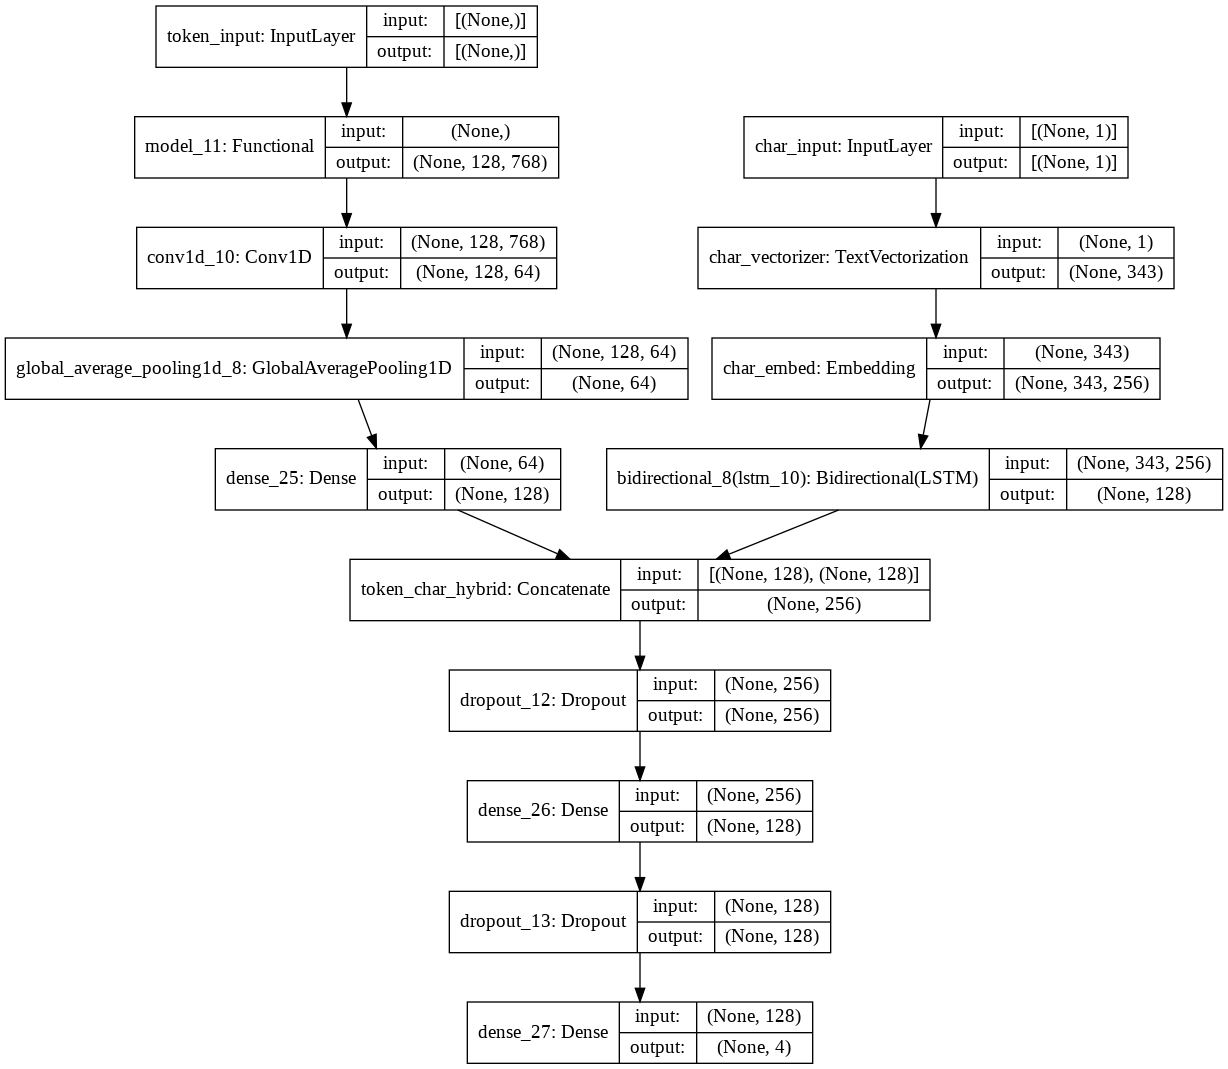

In [ ]:
plot_model(model_5, show_shapes=True)

In [ ]:
# fitting the model
model_5_hist = model_5.fit(train_char_token_dataset, 
                            steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                            epochs=10,
                            validation_data=test_char_token_dataset,
                            validation_steps=int(0.1 * len(test_char_token_dataset)))

Epoch 1/10
375/375 [==============================] - 155s 392ms/step - loss: 0.4576 - accuracy: 0.8414 - val_loss: 0.3855 - val_accuracy: 0.8804
Epoch 2/10
375/375 [==============================] - 143s 382ms/step - loss: 0.3449 - accuracy: 0.8917 - val_loss: 0.3439 - val_accuracy: 0.8804
Epoch 3/10
375/375 [==============================] - 144s 384ms/step - loss: 0.3165 - accuracy: 0.9011 - val_loss: 0.3485 - val_accuracy: 0.8913
Epoch 4/10
375/375 [==============================] - 143s 382ms/step - loss: 0.3028 - accuracy: 0.9025 - val_loss: 0.3171 - val_accuracy: 0.8886
Epoch 5/10
375/375 [==============================] - 144s 383ms/step - loss: 0.2880 - accuracy: 0.9072 - val_loss: 0.3257 - val_accuracy: 0.8967
Epoch 6/10
375/375 [==============================] - 143s 382ms/step - loss: 0.2908 - accuracy: 0.9046 - val_loss: 0.3130 - val_accuracy: 0.8927
Epoch 7/10
375/375 [==============================] - 143s 382ms/step - loss: 0.2707 - accuracy: 0.9084 - val_loss: 0.3415 -

In [ ]:
evaluate_model(model_5, test_char_token_dataset)

238/238 [==============================] - 81s 339ms/step - loss: 0.2510 - accuracy: 0.9133


## Comparing The Model Results

In [ ]:
# Getting the precision, recall and f1 scores for the baseline model
y_preds = model_0.predict(test_text)
model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels, y_preds, average="weighted")
baseline_results = {"accuracy": baseline_score,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}

In [ ]:
# Adding the baseline results to the results dictionary 
results['basline_multinomialNB'] = baseline_results

In [ ]:
# Converting the results dictionary into a pandas dataframe
results_df = pd.DataFrame.from_dict(results).transpose()
results_df.sort_values('accuracy', ascending=False)

,accuracy,precision,recall,f1
model_1_conv1d_token_embedding,0.918289,0.918261,0.918289,0.918166
model_3_bilstm_char_conv1d_token_embedding,0.917895,0.917885,0.917895,0.917761
model_4_bert_token_embedding_lstm,0.917500,0.917734,0.917500,0.917606
model_5_conv1d_bert_token_and_bilstm_char_embeddings,0.913289,0.913431,0.913289,0.913178
model_2_USE_token_embedding,0.903026,0.903465,0.903026,0.902964
basline_multinomialNB,0.902105,0.901746,0.902105,0.901834


## Saving The Best Model

In [ ]:
model_1.save(f'{model_1.name}')

INFO:tensorflow:Assets written to: model_1_conv1d_token_embedding/assets


INFO:tensorflow:Assets written to: model_1_conv1d_token_embedding/assets


## Most Wrong Predictions Of The Best Model

In [ ]:
# Loading the best model
model_path = model_1.name
best_model = tf.keras.models.load_model(model_path)

test_pred_probs = best_model.predict(test_dataset,verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

238/238 [==============================] - 1s 3ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 3, 3, 3, 3, 3, 3, 3, 3, 2])>

In [ ]:
# checking the class names
class_names

['World', 'Sports', 'Business', 'Sci/Tech']

In [ ]:
# Getting a list of class names of the test predictions
test_pred_classes = [class_names[pred] for pred in test_preds]
test_pred_classes[:10]

['Business',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Sci/Tech',
 'Business']

In [ ]:
# Creating prediction-enriched test dataframe
test_df = pd.DataFrame(dataset['test'])
test_df['class_name'] = [class_names[label] for label in test_df['label'].tolist()]
test_df["prediction"] = test_pred_classes # creating column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # getting the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["class_name"] # creating a binary column for whether the prediction is right or not
test_df.head(20)

,text,label,class_name,prediction,pred_prob,correct
0,Fears for T N pension after talks Unions repre...,2,Business,Business,0.845059,True
1,The Race is On: Second Private Team Sets Launc...,3,Sci/Tech,Sci/Tech,0.999983,True
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,Sci/Tech,Sci/Tech,0.995309,True
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3,Sci/Tech,Sci/Tech,0.482117,True
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3,Sci/Tech,Sci/Tech,0.729252,True
5,Open Letter Against British Copyright Indoctri...,3,Sci/Tech,Sci/Tech,0.938596,True
6,"Loosing the War on Terrorism \\""Sven Jaschan, ...",3,Sci/Tech,Sci/Tech,0.998810,True
7,"FOAFKey: FOAF, PGP, Key Distribution, and Bloo...",3,Sci/Tech,Sci/Tech,0.878278,True
8,E-mail scam targets police chief Wiltshire Pol...,3,Sci/Tech,Sci/Tech,0.642947,True
9,"Card fraud unit nets 36,000 cards In its first...",3,Sci/Tech,Business,0.525027,False


In [ ]:
# Creating a dataframe with the most wrong predictions
top_wrong_preds_df = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)

In [ ]:
# Investigating the most wrong predictions
for row in top_wrong_preds_df[:10].itertuples(): # adjust indexes to view different samples
  _, text, label, target, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: World, Pred: Sports, Prob: 0.9996696710586548

Text:
Argentina Beats U.S. Men's Basketball Team Argentina defeated the United States team of National Basketball Association stars 89-81 here Friday in the Olympic semi-finals, dethroning the three-time defending champions.

-----

Target: World, Pred: Sports, Prob: 0.9994953870773315

Text:
Sports Court Hears Hamm Gold Medal Appeal LAUSANNE, Switzerland - Paul Hamm appeared before the sports world's highest court Monday to argue why he should he keep his Olympic gymnastics gold medal.    The Court of Arbitration for Sport convened to hear the appeal from a South Korean gymnast who believes he was unfairly deprived of the gold in the men's all-around event in Athens last month because of a scoring error...

-----

Target: World, Pred: Sports, Prob: 0.9994805455207825

Text:
Munro, Morris Face Off in NLCS Game 2 ST. LOUIS - The Houston Astros put their hopes in a pitcher untested in the postseason when they give Pete Munro the ball

For the first 4 samples, the model predicts sports while the target is world news. It is understandable why the model predicts sports becauser they are related to sports events. An Olympic athlete winning a gold medal (the second example) is undoubtedly a sports news, however it can be interpreted as world news as well. Therefore, it is slightly ambiguous whether if the text is mislabelled or the model mispredicted that sample.

On the other hand, a former major leage MVP passing away can be considered more of a world news rather than sports news like the model predicted.

## Making Example Predictions

In [ ]:
# Setting up the sample news dataset
news1 = {}
news1['text'] = 'United Airlines will require its US staff to be vaccinated against COVID-19. The rule will kick in this fall, CEO Scott Kirby and president Brett Hart said in a memo to staff.'
news1['source'] = 'https://www.cnet.com/health/united-airlines-will-require-staff-to-be-vaccinated/'
news2 = {}
news2['text'] = 'Brazil beat Spain in extra time to retain Olympic football gold'
news2['source'] = 'https://www.aljazeera.com/news/2021/8/7/brazil-beat-spain-in-extra-time-to-retain-olympic-football-gold'
news3 = {}
news3['text'] = "Barry the barred owl was flying low in search of a meal when it collided with one of the park's maintenance vans on Friday morning"
news3['source'] = 'https://www.bbc.com/news/world-us-canada-58127413'
news4 = {}
news4['text'] = 'A bounty of potential gravitational wave events hints at exciting possibilities'
news4['source'] = 'https://www.sciencenews.org/article/gravitational-wave-ligo-virgo-new-signals-ripples-spacetime'

sample_news = []
sample_news.append(news1)
sample_news.append(news2)
sample_news.append(news3)
sample_news.append(news4)

sample_news_df = pd.DataFrame(sample_news)
sample_news_df

,text,source
0,United Airlines will require its US staff to b...,https://www.cnet.com/health/united-airlines-wi...
1,Brazil beat Spain in extra time to retain Olym...,https://www.aljazeera.com/news/2021/8/7/brazil...
2,Barry the barred owl was flying low in search ...,https://www.bbc.com/news/world-us-canada-58127413
3,A bounty of potential gravitational wave event...,https://www.sciencenews.org/article/gravitatio...


In [ ]:
# Preparing the sample news for predictions
sample_data = sample_news_df['text'].tolist()
sample_data

['United Airlines will require its US staff to be vaccinated against COVID-19. The rule will kick in this fall, CEO Scott Kirby and president Brett Hart said in a memo to staff.',
 'Brazil beat Spain in extra time to retain Olympic football gold',
 "Barry the barred owl was flying low in search of a meal when it collided with one of the park's maintenance vans on Friday morning",
 'A bounty of potential gravitational wave events hints at exciting possibilities']

In [ ]:
sample_pred_probs = best_model.predict(sample_data)
sample_preds = tf.argmax(sample_pred_probs, axis=1)
pred_classes = [class_names[pred] for pred in sample_preds]
pred_classes

['Business', 'Sports', 'Sci/Tech', 'Sci/Tech']

In [ ]:
sample_news_df['pred'] = pred_classes
sample_news_df['pred_probs'] = tf.reduce_max(sample_pred_probs, axis=1).numpy()
for row in sample_news_df.itertuples():
  _, text, _, prediction, pred_prob = row
  print(f"Text:\n{text}\n")
  print(f"Pred: {prediction}, Prob: {pred_prob}\n")
  print("-----\n")

Text:
United Airlines will require its US staff to be vaccinated against COVID-19. The rule will kick in this fall, CEO Scott Kirby and president Brett Hart said in a memo to staff.

Pred: Business, Prob: 0.5320504903793335

-----

Text:
Brazil beat Spain in extra time to retain Olympic football gold

Pred: Sports, Prob: 0.6981417536735535

-----

Text:
Barry the barred owl was flying low in search of a meal when it collided with one of the park's maintenance vans on Friday morning

Pred: Sci/Tech, Prob: 0.44104406237602234

-----

Text:
A bounty of potential gravitational wave events hints at exciting possibilities

Pred: Sci/Tech, Prob: 0.43269357085227966

-----

